## Setup

In [1]:
import sys
import os

In [2]:
# define the default font size
%matplotlib inline
import matplotlib.pyplot as plt
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend',fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick',labelsize=10)

Creating the images/classification folder (if it doesn't already exist), and define the save_fig() function which is used through this notebook to save the figures


In [3]:
from pathlib import Path
IMAGE_PATH = Path() /'images'/"MNIST"
os.makedirs(IMAGE_PATH,exist_ok=True)

In [4]:
def save_fig(figid, file_extension="png", tight_layout = True, resolution=300):
    path = IMAGE_PATH / f"{figid}.{file_extension}"
    
    if tight_layout:
        plt.tight_layout()
        
    plt.savefig(path, dpi=resolution,format=file_extension)

## Get the data and have a quick look at
### Download data

In [1]:
from sklearn.datasets import fetch_openml


In [2]:
mnist =  fetch_openml("mnist_784", as_frame=False)

In [7]:
print(mnist.DESCR)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

### Quick look at the data

In [3]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [9]:
X, y = mnist.data, mnist.target

In [10]:
X.shape, y.shape

((70000, 784), (70000,))

In [11]:
len(mnist.feature_names)

784

In [12]:
28*28

784

In [13]:
import matplotlib as mpl

In [14]:
def plot_digit(img):
    img_digit = img.reshape(28,28)
    plt.imshow(img_digit, cmap="binary")
    plt.axis("off") 
 

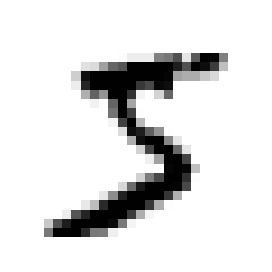

In [15]:
plot_digit(X[0])
save_fig("sample_image_plt")
plt.show() #must be at the end of processing

0


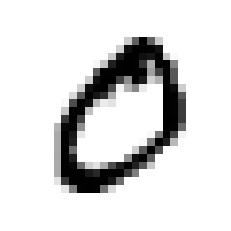

In [16]:
plot_digit(X[1])
print(y[1])
plt.show()

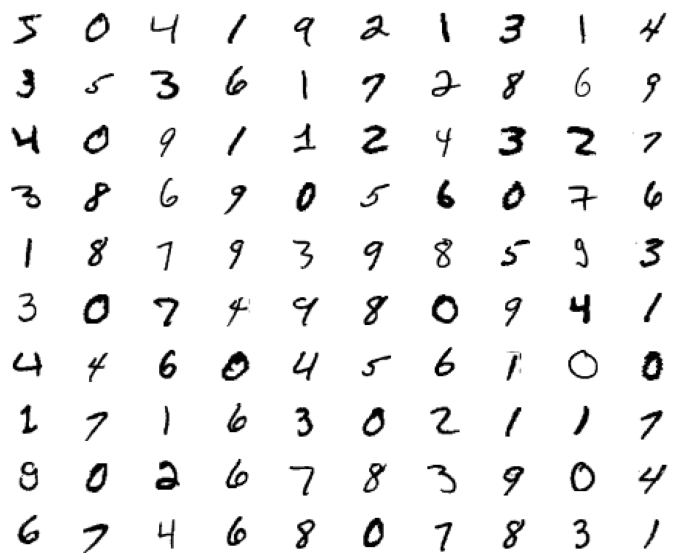

In [17]:
# show first 100 digits
plt.figure(figsize=(10,8))
for idx, image in enumerate(X[:100]):
    plt.subplot(10,10, idx+1)
    plot_digit(image)
    
    plt.subplots_adjust(wspace=0, hspace=0)
save_fig("first_100_images", tight_layout=True)
plt.show()

### Ceate a test set

In [18]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [19]:
X_test.shape, X_train.shape

((10000, 784), (60000, 784))

## Training a model

In [20]:
# start from predict 5
sample_image= X[0]
y_train_5 = (y_train == '5')  #True for all 5s and False for Non 5s
y_test_5 = (y_test == '5')

In [21]:
# using stochastic Gradient Descent(SGD), to repeat the result, we need to set random_state
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(random_state=42)
sgd.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [22]:
sgd.predict([sample_image])

array([ True])

## Performance measures
Accuracy is not a right choice for the skewed dataset 

### Implement cross validation

In [23]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [24]:
skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle= True)
for train_idx, test_idx in skfolds.split(X_train, y_train_5):
    clone_sgd =clone(sgd)
    X_train_fold = X_train[train_idx]
    X_test_fold = X_train[test_idx]
    y_train_fold = y_train_5[train_idx]
    y_test_fold = y_train_5[test_idx]
    
    clone_sgd.fit(X_train_fold, y_train_fold)
    y_hat = clone_sgd.predict(X_test_fold)
    print((y_hat==y_test_fold).sum()/len(y_test_fold))

0.9669
0.91625
0.96785


In [25]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [26]:
from sklearn.base import BaseEstimator


In [27]:
class Non5Estimator(BaseEstimator):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def predict(self, X):
        return np.zeros((len(X),1), dtype=bool)

In [28]:
non_5 = Non5Estimator()
cross_val_score(non_5, X_train, y_train_5, cv=3,scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

In [29]:
from sklearn.dummy import DummyClassifier
dummy_clf =DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train)))

False


In [30]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.90965, 0.90965, 0.90965])

### Confusion Matrix
i. precision = TP/(TP+FP)  
ii. Recall = TP/(TP+FN) This also call True Positive Rate(TPR) or sensitive. It represents how well does the positive instances are correctly detected by the classifier  
iii. Specificity = FP/(FP+TN) This also call False Positive Rate(FPR)  
In general, the higher threshold the better precision(may bumpy sometimes) but worse recall

In [31]:
# getting prediction through cross validation prediction and check the confusion matrix
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd, X_train, y_train_5, cv=3)

In [32]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_train_5, y_train_pred))
cm = confusion_matrix(y_train_5, y_train_pred)

[[53892   687]
 [ 1891  3530]]


In [33]:
# perfect status, only having valus in main diagonal
print(confusion_matrix(y_train_5, y_train_5))


[[54579     0]
 [    0  5421]]


In [34]:
from sklearn.metrics import precision_score, recall_score

In [35]:
print(3530/(3530+687))
precision_score(y_train_5, y_train_pred)

0.8370879772350012


0.8370879772350012

In [36]:
print(3530/(3530+1891))
recall_score(y_train_5, y_train_pred)

0.6511713705958311


0.6511713705958311

In [37]:
from sklearn.metrics import f1_score

In [38]:
print(cm[1,1]/(cm[1,1] + (cm[0,1]+cm[1,0])/2))
f1_score(y_train_5, y_train_pred)

0.7325171197343847


0.7325171197343846

### Precision/Recall trade-off

In [39]:
y_scores = sgd.decision_function([sample_image])
y_scores

array([2164.22030239])

In [40]:
threshold =0
y_sample_image_pred = (y_scores>threshold)
y_sample_image_pred

array([ True])

In [41]:
threshold = 3000
(y_scores > threshold)

array([False])

In [42]:
y_scores = cross_val_predict(sgd, X_train, y_train_5, cv=3,
                            method="decision_function")
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

In [43]:
from sklearn.metrics import precision_recall_curve


In [44]:
precisions, recalls,thresholds = precision_recall_curve(y_train_5, y_scores)


In [45]:
def plot_precision_recall_vs_threshold(precision, recall, threshold):
    plt.figure(figsize=(8,4))
    plt.plot(thresholds,precision[:-1],"b--", label="Precision" )
    plt.plot(thresholds, recall[:-1], "g-", label="Recall")
    plt.vlines(threshold, 0,1.0,'k','dotted',label="Threshold")
    idx = (thresholds>threshold).argmax()
    plt.plot(thresholds[idx], precision[idx],"bo")
    plt.plot(thresholds[idx], recall[idx],"go")
    plt.grid()
    plt.axis([-50000,50000,0,1])
    plt.xlabel("Threshold")
    plt.legend(loc="center right")
    

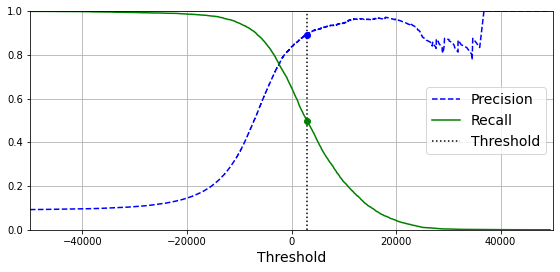

In [46]:
plot_precision_recall_vs_threshold(precisions, recalls, threshold)
save_fig("precision_recall_vs_threshold_plot")
plt.show()

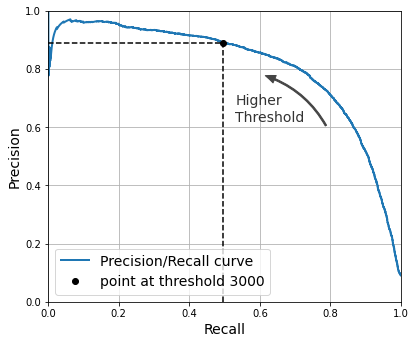

In [47]:
# plot precision versus recall
import matplotlib.patches as patches #for drawing the curved arrow

idx = (thresholds>threshold).argmax()
plt.figure(figsize=(6,5))
plt.plot(recalls, precisions,linewidth=2, label="Precision/Recall curve")
plt.plot([recalls[idx],recalls[idx]], [0,precisions[idx]], 'k--')
plt.plot([0,recalls[idx]], [precisions[idx],precisions[idx]], 'k--')
plt.plot(recalls[idx], precisions[idx],"ko", label="point at threshold 3000")
plt.gca().add_patch(patches.FancyArrowPatch(
(0.79,0.6), (0.61,0.78),
connectionstyle="arc3, rad=.2",
arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
color = "#444444"))
plt.text(0.53, 0.62, "Higher\nThreshold", color="#333333")

plt.axis([0,1, 0, 1])
plt.grid("-")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower left")
save_fig("precision_vs_recall_plot")
plt.show()

In [48]:
threshold_for_90_precision=thresholds[np.argmax(precisions>=0.9)]
threshold_for_90_precision


3370.0194991439557

In [49]:
y_train_pred_90=(y_scores>=threshold_for_90_precision)

In [50]:
print(precision_score(y_train_5, y_train_pred_90))
recall_score(y_train_5, y_train_pred_90)

0.9000345901072293


0.4799852425751706

### The Roc curve
sensitivity vs (1- specificity) 

In [51]:
from sklearn.metrics import roc_curve

In [52]:
fpr, tpr, threshold = roc_curve(y_train_5, y_scores)
idx_for_threshold_at_90 = (threshold<=threshold_for_90_precision).argmax()
idx_for_threshold_at_90

520

In [53]:
fpr_90, tpr_90 = fpr[idx_for_threshold_at_90],tpr[idx_for_threshold_at_90]

In [54]:
def plot_roc_curve(fpr, tpr,label=None):

    plt.plot(fpr,tpr, linewidth =2, label=label)
    plt.plot([0,1.0], [0,1.0], "k--", label ="Random classifier's ROC curve")
    plt.plot(fpr_90, tpr_90,'ro', label="Threshold for 90% precision")
    plt.gca().add_patch(patches.FancyArrowPatch(
       ( 0.2,0.89),(0.07,0.7),
        connectionstyle="arc3, rad=0.4",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
        color="#444444"
    ))
    plt.text(0.12, 0.71, "Higher\nThreshold", color="#333333")
    plt.grid()
    plt.axis([0,1.0, 0,1.0,])
    plt.ylabel("True Positive Rate(Recall)")
    plt.xlabel('False Positive Rate')
    plt.legend(loc="lower right", fontsize=12 )
    

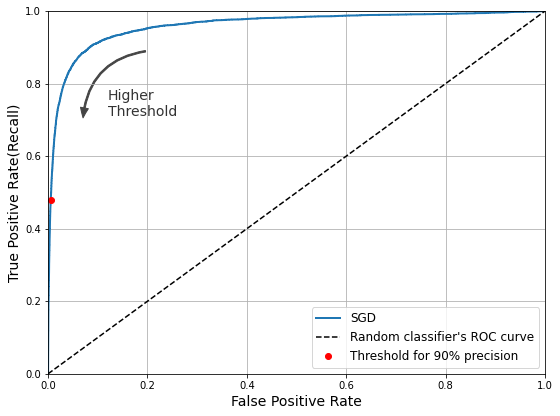

In [55]:
plt.figure(figsize=(8,6))
plot_roc_curve(fpr,tpr,"SGD")
save_fig("roc_curve_plot")
plt.show()

In [56]:
from sklearn.metrics import roc_auc_score

In [57]:
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [58]:
from sklearn.ensemble import RandomForestClassifier

In [59]:
rf_clf= RandomForestClassifier(random_state=42)
y_prob_rf= cross_val_predict(rf_clf, X_train, y_train_5, cv=3,
                            method="predict_proba")
y_prob_rf

array([[0.11, 0.89],
       [0.99, 0.01],
       [0.96, 0.04],
       ...,
       [0.02, 0.98],
       [0.92, 0.08],
       [0.94, 0.06]])

In [60]:
y_scores_rf = y_prob_rf[:, 1]
fpr_rf, tpr_rf, threshold_rf = roc_curve(y_train_5, y_scores_rf)

In [61]:

recall_for_forest =tpr_rf[(fpr_rf>=fpr_90).argmax()]

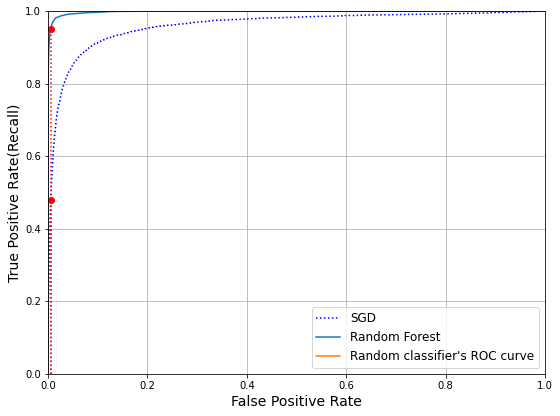

In [62]:
plt.figure(figsize=(8,6))
plt.plot(fpr,tpr, "b:", label="SGD")
plt.plot(fpr_rf, tpr_rf, label="Random Forest")
plt.plot([0,0],[1,1], label="Random classifier's ROC curve")
plt.grid()
plt.plot(fpr_90,tpr_90, "ro")
plt.plot(fpr_90,recall_for_forest,"ro"  )
plt.plot([fpr_90, fpr_90],[0, tpr_90], "r:")
plt.plot([fpr_90, fpr_90],[0, recall_for_forest], "r:")
plt.axis([0,1.0, 0,1.0,])
plt.ylabel("True Positive Rate(Recall)")
plt.xlabel('False Positive Rate')
plt.legend(loc="lower right", fontsize=12 )
save_fig("roc_curve_comparison_plot")
plt.show()

In [63]:
idx_50_60 = (y_prob_rf[:,1]>0.5) & (y_prob_rf[:,1]<0.6)
print(f"{y_prob_rf[idx_50_60].sum()/y_prob_rf.sum():.1%}")
print(f"{y_train_5[idx_50_60].sum()/idx_50_60.sum():.1%}")

0.6%
94.0%


In [64]:
roc_auc_score(y_train_5, y_scores_rf)

0.9983436731328145

In [65]:
y_train_predict_rf = y_scores_rf>=0.5
y_train_predict_rf

array([ True, False, False, ...,  True, False, False])

In [66]:
f1_score(y_train_5, y_train_predict_rf)

0.9274509803921569

In [67]:
precision_score(y_train_5, y_train_predict_rf)

0.9897468089558485

In [68]:
recall_score(y_train_5, y_train_predict_rf)

0.8725327430363402

## Multiclass Classification

In [69]:
# SVMs do not scale well to large data set, so we only train the first 2000 instances
from sklearn.svm import SVC


In [70]:
svc_clf = SVC()
svc_clf.fit(X_train[:2000], y_train[:2000])


SVC()

In [71]:
svc_clf.predict([sample_image])

array(['5'], dtype=object)

In [72]:
svc_clf.decision_function_shape

'ovr'

In [73]:
svc_clf.decision_function([sample_image]).round(2)

array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])

In [74]:
svc_clf.decision_function([sample_image]).argmax()

5

In [78]:
svc_clf.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [79]:
from sklearn.multiclass import OneVsRestClassifier


In [80]:
ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=42))

In [81]:
ovr_clf.predict([sample_image])

array(['5'], dtype='<U1')

In [82]:
len(ovr_clf.estimators_)

10

In [83]:
sgd.fit(X_train, y_train)

SGDClassifier(random_state=42)

In [87]:
# sgd predict the image as 3
sgd.predict([sample_image])

array(['3'], dtype='<U1')

In [88]:
sgd.decision_function([sample_image]).round()

array([[-31893., -34420.,  -9531.,   1824., -22320.,  -1386., -26189.,
        -16148.,  -4604., -12051.]])

In [89]:
cross_val_score(sgd, X_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

In [92]:
# improve the performance if we add standard scaler to X_train
from sklearn.preprocessing import StandardScaler

In [93]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

### Error analysis

In [94]:
from sklearn.metrics import ConfusionMatrixDisplay

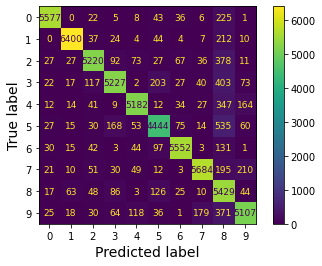

In [123]:
y_train_predict = cross_val_predict(sgd, X_train_scaled, y_train, cv=3)
plt.rc("font", size=9) #making the font smaller
ConfusionMatrixDisplay.from_predictions(y_train, y_train_predict)
plt.show()

In [105]:
import matplotlib.pyplot as plt

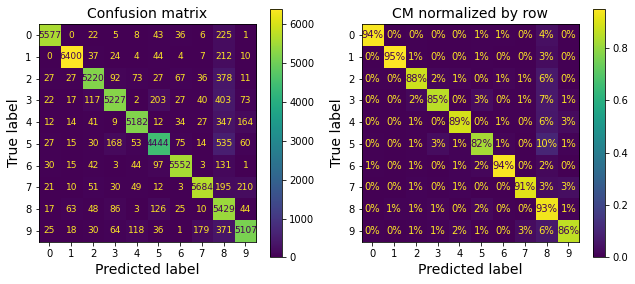

In [106]:
# display the confusion matrix and its normalized one side by side
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(9,4))
plt.rc("font", size=9)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_predict, ax=axs[0])
axs[0].set_title("Confusion matrix")
plt.rc("font", size=10)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_predict, ax=axs[1],
                                       normalize="true", values_format=".0%" )
axs[1].set_title("CM normalized by row")
save_fig("confusion_matrix_plot_1")
plt.show()

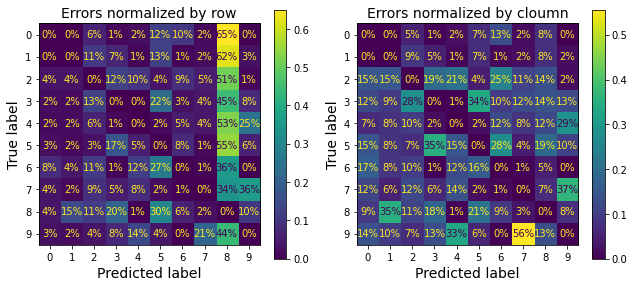

In [108]:
# display the confusion matrix that only keep the incorrect results and its normalized one side by side
sample_weight = (y_train_predict != y_train)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9,4))
plt.rc("font",size=10)
# by row
ConfusionMatrixDisplay.from_predictions(y_train, y_train_predict, ax=axs[0],
                      sample_weight=sample_weight,
                                        normalize="true", values_format=".0%"
                                       )
axs[0].set_title("Errors normalized by row")

ConfusionMatrixDisplay.from_predictions(y_train, y_train_predict, ax= axs[1],
                                       sample_weight=sample_weight,
                                       normalize='pred', values_format=".0%")
axs[1].set_title("Errors normalized by cloumn")
save_fig("confusion_matrix_plot_1")
plt.show()

In [161]:
def plot_digits(instances, images_per_row,**options):
    size = 28 #image size
    images_per_row = min(len(instances), images_per_row)
    n_rows = (len(instances)-1)//images_per_row + 1
    
    # Append empty images to fill the end of the grid, if needed:
    n_empties = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empties, size*size))], axis=0)
    
    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))
    
    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2,1,3).reshape(n_rows*size, images_per_row*size)
    plt.imshow(big_image, cmap= mpl.cm.binary, **options)
    plt.axis("off")

In [164]:
a= np.arange(60).reshape((1,4,5,3))
print(a)
a.transpose(0,2,1,3)

[[[[ 0  1  2]
   [ 3  4  5]
   [ 6  7  8]
   [ 9 10 11]
   [12 13 14]]

  [[15 16 17]
   [18 19 20]
   [21 22 23]
   [24 25 26]
   [27 28 29]]

  [[30 31 32]
   [33 34 35]
   [36 37 38]
   [39 40 41]
   [42 43 44]]

  [[45 46 47]
   [48 49 50]
   [51 52 53]
   [54 55 56]
   [57 58 59]]]]


array([[[[ 0,  1,  2],
         [15, 16, 17],
         [30, 31, 32],
         [45, 46, 47]],

        [[ 3,  4,  5],
         [18, 19, 20],
         [33, 34, 35],
         [48, 49, 50]],

        [[ 6,  7,  8],
         [21, 22, 23],
         [36, 37, 38],
         [51, 52, 53]],

        [[ 9, 10, 11],
         [24, 25, 26],
         [39, 40, 41],
         [54, 55, 56]],

        [[12, 13, 14],
         [27, 28, 29],
         [42, 43, 44],
         [57, 58, 59]]]])

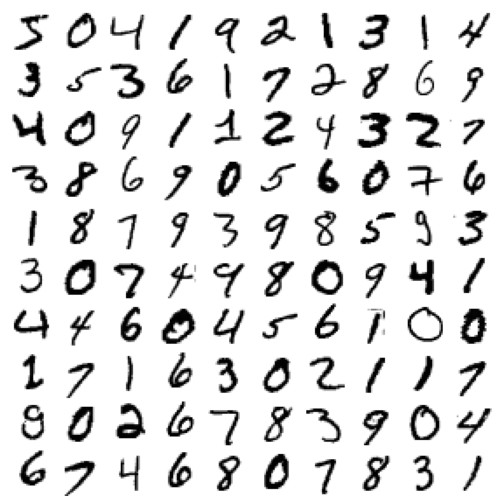

In [162]:
plt.figure(figsize=(9,9))
plot_digits(X_train[:100], images_per_row =10)

In [150]:
# identify correct/incorrect recognized images
cl_a, cl_b = '3', '5'
X_aa = X_train[(y_train == cl_a) & (y_train_predict == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_predict == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_predict == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_predict == cl_b)]


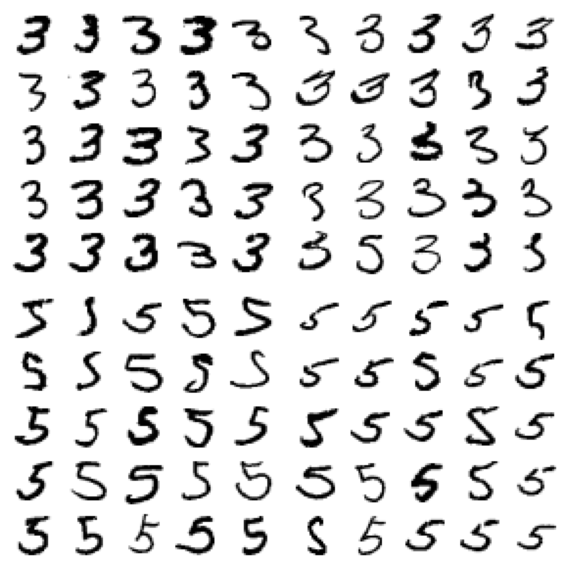

In [169]:
plt.figure(figsize=(8,8))
plt.subplot(221);plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222);plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223);plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224);plot_digits(X_bb[:25], images_per_row=5)
save_fig("error_analysis_digits_plot")
plt.show()

### Multi-label Classification
A classification system that outputs multiple binary tags is called multilabel classification, KNeighborsClassifier can do this

In [170]:
from sklearn.neighbors import KNeighborsClassifier

In [174]:
y_train_large =( y_train >='7')
y_train_odd = (y_train.astype('int64') %2 ==1)

In [177]:
y_multilabel = np.c_[y_train_large, y_train_odd]

In [180]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)
knn_clf.predict([sample_image])

array([[False,  True]])

In [184]:
# calculate the mean of f1 score to evaluate the performances
y_train_knn_pred = cross_val_predict(knn_clf, X_train,
                                     y_multilabel, cv=3)

In [185]:
from sklearn.metrics import f1_score

In [186]:
f1_score(y_multilabel, y_train_knn_pred, average ='macro')

0.976410265560605

In [187]:
# shows that we get a negligible performance improvement when we
#              set average="weighted" because the classes are already pretty
#              well balanced.
f1_score(y_multilabel, y_train_knn_pred, average="weighted")

0.9778357403921755

In [ ]:
# change to svc
from sklearn.multioutput import ClassifierChain
svc =SVC()
chain_clf = ClassifierChain(SVC(), cv=3, random_state=42)
chain_clf.fit(X_train, y_multilabel)

In [189]:
chain_clf.predict([sample_image])

array([[0., 1.]])

### multioutput Classfication
A generalization of multilabel classification where each label can be multiclass

In [193]:
# Add some noise to the images and recognize the images
noise = np.random.randint(0,100, (len(X_train), 784))
X_train_mod = X_train +noise
noise = np.random.randint(0,100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test_mod

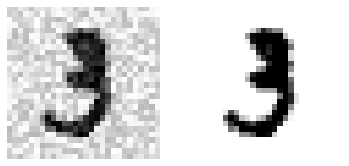

In [198]:
sample_idx = 10
plt.subplot(121); plot_digit(X_train_mod[sample_idx])
plt.subplot(122); plot_digit(X_train[sample_idx])

In [ ]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)

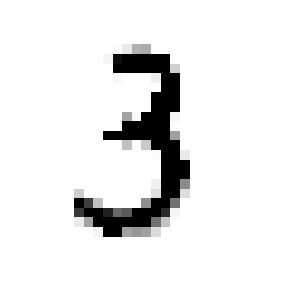

In [199]:
clean_digit = knn_clf.predict([X_train_mod[sample_idx]])
plot_digit(clean_digit)
save_fig("cleaned_digit_example_plot") 
plt.show()

## Improve the accuracy with KNN

In [4]:
from sklearn.datasets import fetch_openml

In [5]:
mnist = fetch_openml("mnist_784", as_frame=False)


In [7]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [9]:
mnist['data']

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [10]:
X,y = mnist['data'], mnist['target']

In [11]:
X.shape

(70000, 784)

In [13]:
X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((60000, 784), (10000, 784), (60000,), (10000,))

In [19]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [17]:
knn_clf = KNeighborsClassifier()
y_score = cross_val_score(knn_clf, X_train, y_train,cv=3, scoring="accuracy" )
y_score

array([0.9676 , 0.9671 , 0.96755])

In [25]:
param_grid = [
    {'weights':['uniform', 'distance'],
    'n_neighbors':[ 4,5, 6,7,8,9, 10]}
]
grid_search_result = GridSearchCV(knn_clf, param_grid, cv=3).fit(X_train,y_train)

In [26]:
grid_search_result.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [27]:
grid_search_result.best_score_

0.9703500000000002

In [28]:
knn_clf_best = KNeighborsClassifier(weights ='distance', n_neighbors= 4)
y_score = cross_val_score(knn_clf_best, X_train, y_train,cv=3, scoring="accuracy" )
y_score

array([0.9709 , 0.9698 , 0.97035])

In [29]:
grid_search_result.best_estimator_.fit(X_train,y_train)
tuned_score = grid_search_result.score(X_test, y_test)
tuned_score

0.9714

## Training set expansion